In [178]:
import os
import pickle
import urllib
import warnings
from ast import literal_eval
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

from scipy.sparse import coo_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense

In [42]:
# Load dataset
data_path = os.path.join('..', 'data', 'rec-exam.csv000')
df = pd.read_csv(data_path, escapechar='\\',
                 dtype={'content_id': str, 'content_type': str, 'server_time_kst': str,
                        'user_id': str, 'device_type': str, 'session_id': str, 
                        'content_owner': str, 'ref_term': str, 'name': str, 'keyword': str,
                        'category_id': str, 'category_name': str, 'image_url': str})

In [43]:
# Check rows and features
df.shape

(3324132, 13)

In [44]:
df.head(3)

,content_id,content_type,server_time_kst,user_id,device_type,session_id,content_owner,ref_term,name,keyword,category_id,category_name,image_url
0,138933030,product,2020-12-07T22:43:23.879+09:00,10000288,i,1607348537-dhOQi3,4424970,NaN,삼성 탭s2 8.0 팝니다,NaN,600700004,태블릿,https://media.bunjang.co.kr/product/138933030_...
1,139850819,product,2020-12-07T22:43:49.605+09:00,10000288,i,1607348537-dhOQi3,10254112,NaN,"[수능끝] 새 문제집 판매 (메가스터디, 마닳 등등)","문제집정리,문제집새거,문제집판매,문과문제집,문과",900100004,학습/사전/참고서,https://media.bunjang.co.kr/product/139850819_...
2,134550780,product,2020-12-07T22:44:31.585+09:00,10000288,i,1607348537-dhOQi3,7990230,NaN,아이나비탭 xd duo 10 s,"아이나비탭,태블릿노트북,2in1노트북,윈도우10,윈도우태블릿pc",600700004,태블릿,https://media.bunjang.co.kr/product/134550780_...


In [5]:
# drop unnecessary columns
drop_cols = ['server_time_kst', 'session_id', 'content_type']
drop_cols_2 = ['device_type', 'content_owner', 'ref_term']
df = df.drop(columns=drop_cols + drop_cols_2, errors='ignore')

In [6]:
# Check each features (count / uniqueness)
df.describe(include=[np.object])

,content_id,user_id,name,keyword,category_id,category_name
count,3324132,3324132,3324132,2941536,3324132,3324132
unique,1322891,226790,1162148,1017289,996,805
top,139677794,1364200,에어팟 프로,프리,600700001,스마트폰
freq,486,700,2957,4243,148712,148712


In [7]:
df.head(3)

,content_id,user_id,name,keyword,category_id,category_name
0,138933030,10000288,삼성 탭s2 8.0 팝니다,NaN,600700004,태블릿
1,139850819,10000288,"[수능끝] 새 문제집 판매 (메가스터디, 마닳 등등)","문제집정리,문제집새거,문제집판매,문과문제집,문과",900100004,학습/사전/참고서
2,134550780,10000288,아이나비탭 xd duo 10 s,"아이나비탭,태블릿노트북,2in1노트북,윈도우10,윈도우태블릿pc",600700004,태블릿


In [8]:
# Cehck NaN values
df.isna().sum()

content_id            0
user_id               0
name                  0
keyword          382596
category_id           0
category_name         0
dtype: int64

In [9]:
# replace NaN with an empty string
# df['ref_term'] = df['ref_term'].fillna('')
df['keyword'] = df['keyword'].fillna('')

### Content-based Filtering

#### Category, Keyword based recommender

In [10]:
# Remove Special characters
spec_chars = ["!", '"', "#", "%", "&", "'", "(", ")", ",", "-", ".", "/", ":", 
              "<", ">", "[", "]", "_", "`", "{", "|", "}" , "~", "–", "+"]

for char in spec_chars:
    df['category_name'] = df['category_name'].str.replace(char, ' ')
    df['name'] = df['name'].str.replace(char, ' ')
    
df['keyword'] = df['keyword'].str.replace(',', ' ')   

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  import sys


In [11]:
# Make metadata
df['meta_data'] = df['category_name'] + ' ' + df['keyword']

In [12]:
df.head(3)

,content_id,user_id,name,keyword,category_id,category_name,meta_data
0,138933030,10000288,삼성 탭s2 8 0 팝니다,,600700004,태블릿,태블릿
1,139850819,10000288,수능끝 새 문제집 판매 메가스터디 마닳 등등,문제집정리 문제집새거 문제집판매 문과문제집 문과,900100004,학습 사전 참고서,학습 사전 참고서 문제집정리 문제집새거 문제집판매 문과문제집 문과
2,134550780,10000288,아이나비탭 xd duo 10 s,아이나비탭 태블릿노트북 2in1노트북 윈도우10 윈도우태블릿pc,600700004,태블릿,태블릿 아이나비탭 태블릿노트북 2in1노트북 윈도우10 윈도우태블릿pc


In [13]:
# define a TF-IDF vetorizer object
categories = list(df['category_id'].unique())
df_temp = df[['category_id', 'meta_data']].copy().to_numpy()

df_by_category = {}
for category in categories:
    mask = np.where(df_temp[:, 0] == category, True, False)
    temp =  df_temp[mask][:, 1]
    df_by_category[category] = temp

In [ ]:
# # define a TF-IDF vetorizer object
# tfidf = TfidfVectorizer()

# tfidf_by_category = {}
# for category, meta_data in df_by_category.items():
#     tfidf_matrix = tfidf.fit_transform(meta_data)
#     tfidf_by_category[category] = tfidf_matrix

In [ ]:
# tfidf_sim_by_category = {}
# for category, tfidf in tfidf_by_category.items():
#     cosine_sim = linear_kernel(tfidf, tfidf)
#     tfidf_sim_by_category[category] = cosine_sim

In [ ]:
# difne count vetorizer object
count = CountVectorizer()
cnt_by_category = {}
for category, meta_data in df_by_category.items():
    count_matrix = count.fit_transform(meta_data)
    cnt_by_category[category] = count_matrix

In [ ]:
save_path = os.path.join('..', 'result')
with open(os.path.join(save_path, 'cnt_vec_by_category.pickle'), 'wb') as handle:
    pickle.dump(cnt_by_category, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
load_path = os.path.join('..', 'result')
with open(os.path.join(load_path, 'cnt_vec_by_category.pickle'), 'rb') as handle:
    cnt_by_category = pickle.load(handle)

In [ ]:
# cnt_sim_by_category = {}
# for category, cnt in cnt_by_category.items():
#     cosine_sim = cosine_similarity(cnt, cnt)
#     cnt_sim_by_category[category] = cosine_sim

In [15]:
indices = pd.Series(df.index, index=df['content_id'])

In [16]:
# make content_id to category map
content_to_cate = pd.Series(df['category_id'].values, index=df['content_id'].values).to_dict()

In [29]:
def content_based_recommend(content_id):
    idx = indices[content_id]
    category = content_to_cate[content_id]
    cnt_matrix = cnt_by_category[category]
    cosine_sim = cosine_similarity(cnt_matrix, cnt_matrix)
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # get scores of the 8 most similar items
    sim_scores = sim_scores[1: 1+8]
    
    # Get the content
    content_indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]
    
    return content_indices, scores

In [30]:
# Recommendation test sample
df[df['content_id'] == '138933030']

,content_id,user_id,name,keyword,category_id,category_name,meta_data
0,138933030,10000288,삼성 탭s2 8 0 팝니다,,600700004,태블릿,태블릿


In [35]:
# Recommendation test
recommend_indices, sim_scores = content_based_recommend(content_id='138933030')
print(f'recommend Indices: {recommend_indices}')
print(f'Similarity Scores: {sim_scores}')

recommend Indices: [4, 13, 24, 28, 36, 37, 42, 46]
Similarity Scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [41]:
df.iloc[recommend_indices, :]

,content_id,user_id,name,keyword,category_id,category_name,meta_data
4,138738902,10000288,급처 아이패드 미니5 스그 wifi,미니5 64 와이파이 싼가격 미니,600700004,태블릿,태블릿 미니5 64 와이파이 싼가격 미니
13,139135485,10000288,아이패드 에어1 A1475,아이패드에어,600700004,태블릿,태블릿 아이패드에어
24,139820130,10000288,아이패드 7세대,아이패드 아이패드7세대 아이패드8세대 애플 태블릿,600700004,태블릿,태블릿 아이패드 아이패드7세대 아이패드8세대 애플 태블릿
28,139620879,10000288,새상품 아이패드7세대 wifi 셀룰라 32기가 미개봉,아이패드7세대셀룰 그레이 미개봉,600700004,태블릿,태블릿 아이패드7세대셀룰 그레이 미개봉
36,139442897,10000288,아이패드 A1474 16GB 팝니다,아이패드 A1474,600700004,태블릿,태블릿 아이패드 A1474
37,139875661,10000288,아이패드7세대 개봉 상태s,아이폰 애플,600700004,태블릿,태블릿 아이폰 애플
42,139466804,10000288,아이패드 7세대 wifi,,600700004,태블릿,태블릿
46,135489948,10000288,풀박스 이번주만 아이패드 7세대 wifi 32GB,애플 아이패드 7세대 wifi 로즈골드,600700004,태블릿,태블릿 애플 아이패드 7세대 wifi 로즈골드


In [155]:
def plot_recommendation(df, content_id, recommend_indices, sim_scores):
    target_df = df[df['content_id'] == content_id]
    f = urllib.request.urlopen(target_df['image_url'].values[0])
    
    fig = plt.figure(figsize=(2.7, 2.7))
    plt.axis('Off')
    plt.text(0, -60, s=f"Target ID: {content_id}", fontsize=15, weight='bold')
    plt.text(0, -10, s=f"{target_df['name'][0]}", fontsize=10)
    plt.text(0, 400, s="Recommended Items", fontsize=15, weight='bold')
    img = Image.open(f)
    plt.imshow(img)
    
    ncols = 4
    nrows = 4
    fig = plt.figure()
    fig.set_size_inches(ncols * 5, nrows * 5)

    df_rec = df.iloc[recommend_indices, :]
    
    # create a file-like object from the url
    for i, (content_id, name, image_url) in enumerate(zip(df_rec['content_id'], 
                                                        df_rec['name'], 
                                                        df_rec['image_url'])):
        f = urllib.request.urlopen(image_url)
        sp = plt.subplot(nrows, ncols, i+1)
        sp.axis('Off')
        plt.text(0, -40, s=f"ID: {content_id}", fontsize=15)
        plt.text(0, -10, s=f"{name} | {sim_scores[i]}", fontsize=15)
        img = Image.open(f)
        plt.imshow(img)
    
    plt.show()

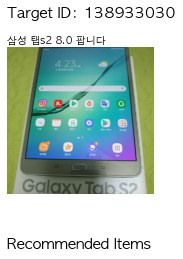

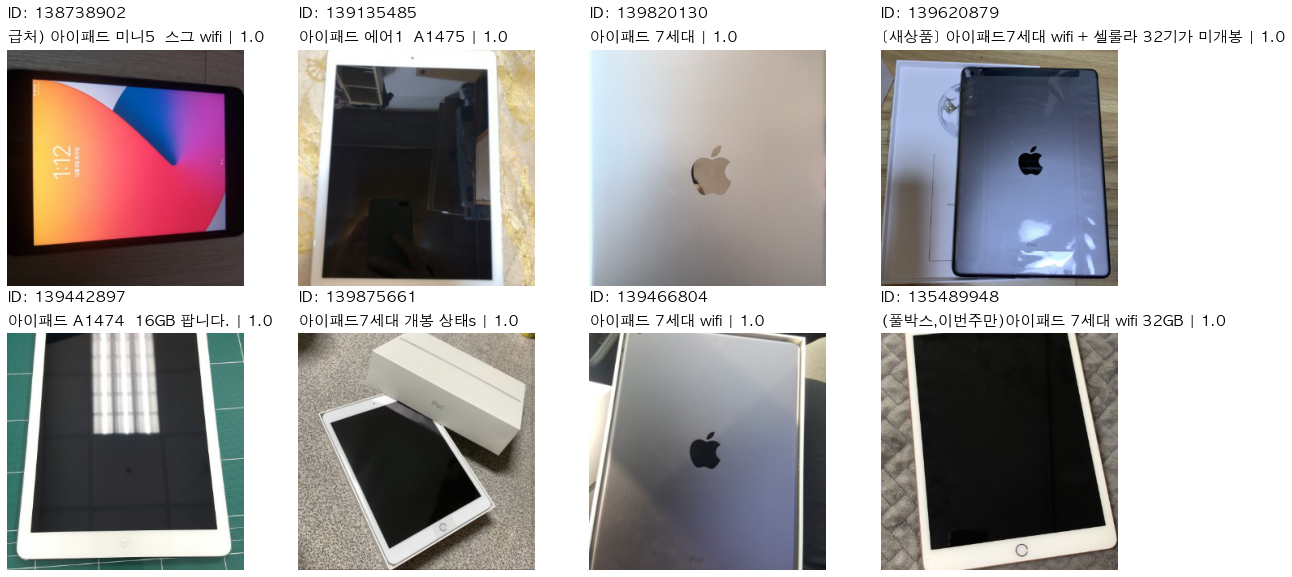

In [156]:
plot_recommendation(df=df, content_id='138933030', 
                    recommend_indices=recommend_indices, sim_scores=sim_scores)

### Collaborative Filtering
<br>
collaborative filtering recommendation using user view(click) log

In [168]:
# Using view count
view = df[['user_id', 'content_id']].copy()

In [169]:
view['view'] = 1
view.head()

,user_id,content_id,view
0,10000288,138933030,1
1,10000288,139850819,1
2,10000288,134550780,1
3,10000288,138289348,1
4,10000288,138738902,1


In [171]:
# get content view counts for each user 
view_cnt = view.groupby(['user_id', 'content_id']).sum().reset_index()

In [188]:
# filter at least user click twice
view_cnt_filtered = view_cnt[view_cnt['view'] > 1]

In [191]:
# calcualte singular value decomposition(SVD)
reader = Reader()
data = Dataset.load_from_df(view_cnt_filtered[['user_id', 'content_id', 'view']], reader)
svd= SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5)

{'test_rmse': array([1.82756708, 1.89904996, 1.92444967, 1.88803495, 1.85813158]),
 'test_mae': array([0.97277841, 0.98200974, 0.98696011, 0.97722209, 0.96984501]),
 'fit_time': (19.763368844985962,
  19.66396403312683,
  18.902668714523315,
  18.926984310150146,
  19.0334210395813),
 'test_time': (0.9146888256072998,
  0.9349586963653564,
  0.9354650974273682,
  0.9410040378570557,
  0.9198758602142334)}

In [192]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
svd.predict()

In [193]:
save_path = os.path.join('..', 'result')
with open(os.path.join(save_path, 'view_cnt_svd.pickle'), 'wb') as handle:
    pickle.dump(svd, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [195]:
svd.predict('10000288', '139850819')

Prediction(uid='10000288', iid='139850819', r_ui=None, est=3.93601174632163, details={'was_impossible': False})

In [242]:
# Recommendation with collaborative filtering 
# Ranking on estimated view count
# recommend contents involed in its category
def collaborative_filtering_recommend(user_id, content_id, svd=svd):
    # contents involved in its category 
    category = content_to_cate[content_id]
    contents = df[df['category_id'] == category]['content_id'].values
    
    # remove itself
    contents = contents[~np.isin(contents, content_id)]

    # estimate involved category contents
    est_view_cnt = []
    for content in contents:
        est = svd.predict(user_id, content)
        est_view_cnt.append([est.iid, est.est])
        
    est_view_cnt = pd.DataFrame(est_view_cnt, columns=['content_id', 'est_view'])
    
    # Remove duplicated results
    est_view_cnt = est_view_cnt.drop_duplicates()
    
    # rank on estimated view count
    est_view_cnt = est_view_cnt.sort_values(by=['est_view'], ascending=False)    
    
    # Filter most 8 view counts  
    est_view_cnt = est_view_cnt.iloc[:8, :]

    return est_view_cnt

In [243]:
est_view = collaborative_filtering_recommend(user_id='10000288', content_id='138933030')

In [272]:
def plot_recommen_cf(df, user_id, content_id, recommend_contents):
    # plot target image
    target_df = df[df['content_id'] == content_id]
    f = urllib.request.urlopen(target_df['image_url'].values[0])
    
    fig = plt.figure(figsize=(2.7, 2.7))
    plt.axis('Off')
    plt.text(0, -60, s=f"Target ID: {content_id}", fontsize=15, weight='bold')
    plt.text(0, -10, s=f"{target_df['name'][0]}", fontsize=10)
    plt.text(0, 400, s="Recommended Items", fontsize=15, weight='bold')
    img = Image.open(f)
    plt.imshow(img)

    # plot recommendation image
    ncols = 4
    nrows = 4
    fig = plt.figure()
    fig.set_size_inches(ncols * 5, nrows * 5)

    df_rec = df[df['content_id'].isin(recommend_contents['content_id'])].drop_duplicates(subset=['content_id'])
    df_rec = df_rec.merge(recommend_contents, on='content_id', right_index=False)
    df_rec = df_rec.sort_values(by=['est_view'], 
                                ascending=False)[['content_id', 'name', 'image_url', 'est_view']]
    
    # create a file-like object from the url
    for i, (content_id, name, image_url) in enumerate(zip(df_rec['content_id'], 
                                                          df_rec['name'], 
                                                          df_rec['image_url'])):
        f = urllib.request.urlopen(image_url)
        sp = plt.subplot(nrows, ncols, i+1)
        sp.axis('Off')
        plt.text(0, -40, s=f"ID: {content_id}", fontsize=15)
        est_view = round(df_rec['est_view'][i], 2)
        plt.text(0, -10, s=f"{name} | {est_view}", fontsize=15)
        img = Image.open(f)
        plt.imshow(img)
    
    plt.show()

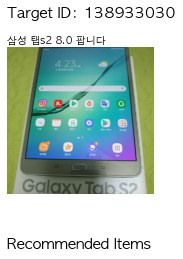

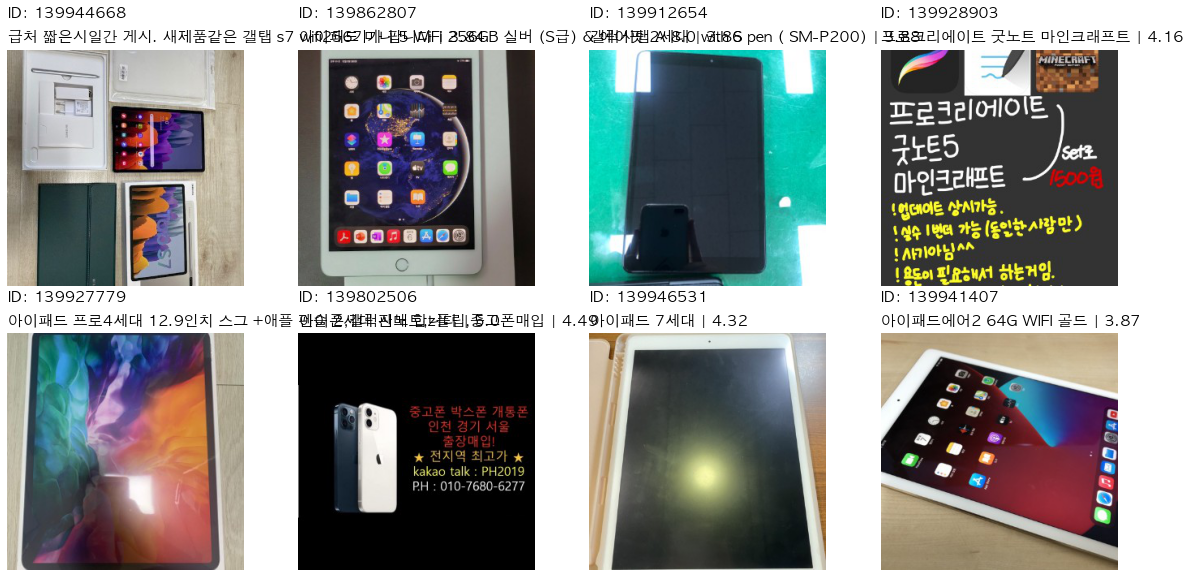

In [273]:
plot_recommen_cf(df=df, user_id='10000288', content_id='138933030', recommend_contents=est_view)